# Plot of a radial temperature chart 

In this post, we will plo a radial temperature chart using daily temperature from Environment Canada. 

The objective of this product is to obtain an analysis of the daily evolution of the temperature and its positioning in relation to the norm and the historical records of the Julian day.

In this work, we will extract data from Environment and Climate Change Canada for the RIGAUD station in Quebec. Here is the information about this station:

    Name: RIGAUD
    Username: 5252
    Latitude: 45.5 degN
    Longitude: -74.37 degW
    Period covered: 1963 - today


A list of stations is available on this site: ftp://ftp.tor.ec.gc.ca/Pub/Get_More_Data_More_data/Repository%20of%20stations%20FR.csv

The data will be uploaded directly to Environment and Climate Change Canada's website http://climate.weather.gc.ca/

The data is in XML format. XML or eXtensible Markup Language is a generic markup language. To read this format, we will call the 'xml.etree.ElementTree' library: https://docs.python.org/2/library/xml.etree.elementtree.html#module-xml.etree.ElementTree


First, we import the necessary libraries:

    - matplotlib: module to plot our graph
    - datetime: python module for manipulating dates
    - wget: module to extract data on a url
    - pandas: module for working with data structures
    - os: "system" module to create, delete ... files from our environment

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from datetime import date
import os
import wget
import pandas as pd
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings("ignore")

For example, we will extract the year 2000 daily records of the station RIGAUD (ID: 5252).

In [13]:
id_stat = 5252
year = 2000
tmp_file = wget.download('http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=xml&stationID='+str(int(id_stat))+'&Year='+str(year)+'&Month=01&Day=14&timeframe=2')
tree=ET.parse(tmp_file)
os.remove(tmp_file)
root=tree.getroot()
stationsdata = root.findall('.//stationdata')

-1 / unknown

Notre fichier XML a la structure suivant:  
Our XML file got this structure: 

 <stationdata year="1955" month="1" day="1">
    <maxtemp units="°C" description="Maximum Temperature">3.3</maxtemp>
    <mintemp units="°C" description="Minimum Temperature">-4.4</mintemp>
    <meantemp units="°C" description="Mean Temperature">-0.6</meantemp>
    <heatdegdays units="°C" description="Heating Degree Days">18.6</heatdegdays>
    <cooldegdays units="°C" description="Cooling Degree Days">0.0</cooldegdays>
    <totalrain units="mm" description="Total Rain">0.0</totalrain>
    <totalsnow units="cm" description="Total Snow">0.0</totalsnow>
    <totalprecipitation units="mm" description="Total Precipitation">0.0</totalprecipitation>
    <snowonground units="cm" description="Snow on Ground"/>
    <dirofmaxgust units="10s Deg" description="Direction of Maximum Gust"/>
    <speedofmaxgust units="km/h" description="Speed of Maximum Gust"/>
</stationdata>

We need to target the maxtemp and mintemp tags for our work, so the stationdata[0] and station[1] fields.

In [16]:
resultmax = []
resultmin = []
for stationdata in stationsdata:
    champs1=stationdata.find('maxtemp')              
    resultmax.append(champs1.text)   #  we append data for each day in a year 
    data_max=np.array(resultmax,"float")     
for stationdata in stationsdata:
    champs2=stationdata.find('mintemp')              
    resultmin.append(champs2.text)   #  we append data for each day in a year 
    data_min=np.array(resultmin,"float") 

We then have two python lists with daily minimum and maximum temperatures.  

In [18]:
print(resultmax[0:5])

['-1.0', '5.5', '2.0', '4.0', '-3.0']


We can do the same over the whole recording period of the station (1963-2019) by applying a for loop over the years.

For each year and each variable to be extracted we will increment a list in the variables min_array = [] and max_array = [].

In [29]:
yi = 1963
yf = 2019
id_stat = 5252
station = 'RIGAUD'
max_array = []
min_array = []
for year in range(yi,yf+1):    ### loop over yars 
    tmp_file = wget.download('http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=xml&stationID='+str(int(id_stat))+'&Year='+str(year)+'&Month=01&Day=14&timeframe=2')
    tree=ET.parse(tmp_file)
    os.remove(tmp_file)
    root=tree.getroot()
    stationsdata = root.findall('.//stationdata')
    resultmax = []
    resultmin = []
    for  stationdata in stationsdata:
         champs1=stationdata.find('maxtemp')              
         resultmax.append(champs1.text)   #  loop over days for tmax 
         data_max=np.array(resultmax,"float")     
    for  stationdata in stationsdata:
         champs2=stationdata.find('mintemp')              
         resultmin.append(champs2.text)   #  loop over days for tmin 
         data_min=np.array(resultmin,"float") 
         
    max_array.append(data_max)
    min_array.append(data_min)
len(max_array)

-1 / unknown

57

For each min_array and max_array fields, we get a list of lists. We will flatten thoses lists: 

In [30]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [31]:
min_array=flatten(min_array) 
max_array=flatten(max_array)
len(min_array)

20819

So we now have two lists of 20454 days for each min_array and max_array fields.

Knowing that the period extends from January 1, 1963 to December 31, 2018, we can add a temporal dimension to our dataframe with the datetime module of python.

In [35]:
start = date(1963, 1, 1)
end = date(2019, 12, 31)
delta=(end-start) 
nb_days = delta.days + 1 
rng = pd.date_range(start, periods=nb_days, freq='D')
tmin_dataset = pd.Series(min_array, index=rng)
tmax_dataset = pd.Series(max_array, index=rng)
tmax_dataset.head()

1963-01-01   -11.1
1963-01-02    -6.7
1963-01-03    -3.9
1963-01-04    -2.2
1963-01-05    -3.9
Freq: D, dtype: float64

One of the big advantages of the pandas dataframe is that we can very easily work with time series.
Here we will calculate the daily climatologies of the tmin_dataset and tmax_dataset variables over the 1981-2010 normal period.

Also, with the pandas groupby tools, we can calculate the daily minimum and maximum of tmin_dataset and tmax_dataset over the full period of the recording.

In [36]:
mintmin = []
maxtmax = []
climtmin = []
climtmax = []

clim_min_dataset=tmin_dataset['1981':'2010']
clim_max_dataset=tmax_dataset['1981':'2010']
climtmin = clim_min_dataset.groupby([clim_min_dataset.index.month, clim_min_dataset.index.day]).mean()
climtmax = clim_max_dataset.groupby([clim_max_dataset.index.month, clim_max_dataset.index.day]).mean()

mintmin = tmin_dataset.groupby([tmin_dataset.index.month, tmin_dataset.index.day]).min()
maxtmax = tmax_dataset.groupby([tmax_dataset.index.month, tmax_dataset.index.day]).max()


data_min_tmin=np.array(mintmin,"float")  
data_max_tmax=np.array(maxtmax,"float") 
data_clim_tmax=np.array(climtmax,"float")     
data_clim_tmin=np.array(climtmin,"float") 

print(len(data_clim_tmax))
print(len(maxtmax))


366
366


We can know visualize our timeries with a radial chart. 

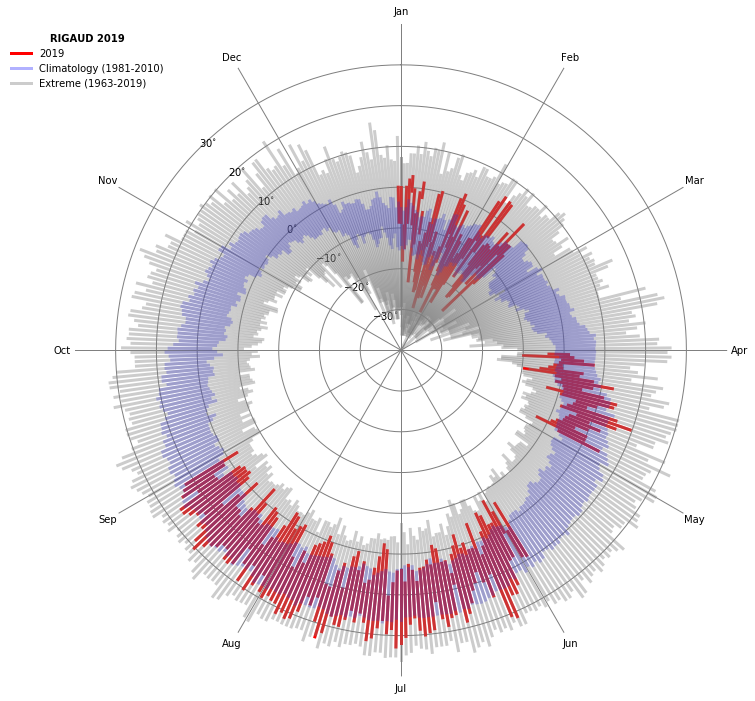

In [37]:
x = []
ndays=366
Azs=np.arange(0,ndays)
angle = Azs * 2.0 * np.pi / ndays

fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, polar=True)

ax.plot([angle[0],angle[0]], [data_min[0],data_max[0]],'red', alpha=1.0, linewidth=3.0, label=str(yf))
ax.plot([angle[0],angle[0]], [data_clim_tmin[0],data_clim_tmax[0]],'blue', alpha=0.3, linewidth=3.0, label='Climatology (1981-2010)')
ax.plot([angle[0],angle[0]], [data_min_tmin[0],data_max_tmax[0]],'grey', alpha=0.4, linewidth=3.0, label='Extreme ('+str(yi)+'-'+str(yf)+')')

leg=plt.legend(bbox_to_anchor=(0.15, 1.0),fontsize=10)
leg.get_frame().set_linewidth(0.0)
leg.set_title(str(station)+' '+str(yf), prop={'size': 10, 'weight': 'heavy'})

ax.plot([angle,angle], [data_min,data_max],'red', alpha=1.0, linewidth=3.0)
ax.plot([angle,angle], [data_clim_tmin,data_clim_tmax],'blue', alpha=0.3, linewidth=3.0)
ax.plot([angle,angle], [data_min_tmin,data_max_tmax],'grey', alpha=0.4, linewidth=3.0)

ax.set_rmin(-40)
ax.set_rmax(+40)
ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)

ax.set_rticks([-30,-20, -10, 0, 10, 20, 30])  # less radial ticks
ax.set_rlabel_position(-45.)  # get radial labels away from plotted line
ax.set_yticklabels(['$-30^{\circ}$', '$-20^{\circ}$', '$-10^{\circ}$', '$0^{\circ}$', '$10^{\circ}$', '$20^{\circ}$', '$30^{\circ}$' ],
   fontsize=10)

# Set the major and minor tick locations
ax.xaxis.set_major_locator(ticker.MultipleLocator(np.pi/6))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(np.pi/12))
ax.grid(linewidth=1,color='grey', linestyle='-')

# Turn off major tick labels
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.set_frame_on(False)

# Set the minor tick width to 0 so you don't see them
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

# Set the names of your ticks, with blank spaces for the major ticks
ax.set_xticklabels(['','Jan','','Feb','','Mar','','Apr','','May','','Jun','','Jul','','Aug','','Sep','','Oct','','Nov','','Dec'],minor=True)

plt.show()
